In [1]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from torch_snippets import *
from torchsummary import summary
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# model

In [2]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [3]:
import math
class resDiscriminator(nn.Module):
    def __init__(self,reduction=5,repeat=0,divisor=1,n_map=64,img_size=64,
                 relu=0.2,n_features=64,feature_dim=8,minibatch_input_dim=128,dropout=0.1):
        super().__init__()
        max_reduction = int(math.log2(img_size//4))
        #print(f"max reduction {max_reduction}")
        self.reduction = min(reduction,max_reduction)
        self.reduction_p2 = max_reduction - self.reduction
        #print(f"reduction 1: {self.reduction}")
        #print(f"reduction 2: {self.reduction_p2}")
        self.final_map_size = 4
        #print(f"final map size: {self.final_map_size}")
        self.final_n_map = n_map * 2**(self.reduction-1)
        #print(f"final n map is: {self.final_n_map}")
        self.minibatch_input_dim = minibatch_input_dim
        self.dropout = nn.Dropout2d(dropout)
        self.n_features = n_features
        self.feature_dim = feature_dim
        self.relu = relu
        self.repeat = repeat
        self.divisor = divisor
        self.activation = nn.LeakyReLU(self.relu)
        self.minibatch_linear = nn.Linear(minibatch_input_dim,n_features*feature_dim)
        self.final_dense = nn.Linear(self.minibatch_input_dim+n_features*2,1)
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3,n_map,4,2,1,bias=False), # /2
            nn.BatchNorm2d(n_map),
        )

        # self.initial_block_bn = nn.Sequential(
        #     nn.Conv2d(3,n_map//4,3,1,1,bias=False), # =
        #     nn.BatchNorm2d(n_map//4),
        #     nn.LeakyReLU(self.relu),
        #     nn.Conv2d(n_map//4,n_map//4,4,2,1), # /2
        #     nn.BatchNorm2d(n_map//4),
        #     nn.LeakyReLU(self.relu),
        #     nn.Conv2d(n_map//4,n_map,3,1,1,bias=False), # =
        #     nn.BatchNorm2d(n_map)
        # )
        n = n_map
        self.conv_blocks = nn.ModuleList(
            [self._normal_block(n*2**i,n*2**(i+1)) for i in range(self.reduction-1)]
        )
        # self.bn_shrink_blocks = nn.ModuleList(
        #     [self._bottleneck_block(n*2**i,n*2**(i+1),True) for i in range(self.reduction-1)]
        # )
        self.bn_repeat_blocks = nn.ModuleList(
            [self._bottleneck_block(n*2**(i+1),n*2**(i+1),False) for i in range(self.reduction-1) for _ in range(repeat)]
        )
        #print(self.final_n_map)
        self.final_conv = nn.ModuleList(
            [self._normal_block(self.final_n_map,self.final_n_map) for _ in range(self.reduction_p2)] + \
                [nn.Conv2d(self.final_n_map,minibatch_input_dim,4,1,0)]
        )

    
    def _normal_block(self,in_c,out_c):
        return nn.Sequential(nn.Conv2d(in_c,out_c,4,2,1,bias=False),nn.BatchNorm2d(out_c)) # /2
    
    def _bottleneck_block(self,in_c,out_c,shrink=True):
        # if shrink, in the middle layer output = (64 + 2 - 4) / 2 + 1 = 32
        # if not shrink, output = (64+2-3) / 1 + 1 = 64
        stride = 2 if shrink else 1
        kernel = 4 if shrink else 3
        middle_c = out_c // self.divisor
        block = nn.Sequential(
            # nn.Conv2d(in_c,middle_c,3,1,1,bias=False), # =
            # nn.BatchNorm2d(middle_c),
            # nn.LeakyReLU(self.relu),
            # nn.Conv2d(middle_c,middle_c,kernel,stride,1,bias=False), # /2 or = 
            # nn.BatchNorm2d(middle_c),
            # nn.LeakyReLU(self.relu),
            nn.Conv2d(middle_c,out_c,3,1,1,bias=False), # =
            nn.BatchNorm2d(out_c)    
        )
        return block
    
    def _minibatch_discrimination(self,x):
        n_feature,feature_dim = self.n_features, self.feature_dim
        batch_size = x.shape[0]
        x_copy = x.clone()
        x = self.minibatch_linear(x) # e.g., (4, 6)
        #print(f"after linear layer x shape: {x.shape}")
        x = x.view(-1,n_feature,feature_dim) # e.g., (4,3,2)
        #print(f"after reshape x shape: {x.shape}")
        # create mask
        mask = torch.eye(batch_size) # (4,4)
        mask = mask.unsqueeze(1) # (4, 1, 4)
        mask = (1 - mask).to('cuda')
        # calculate diff between features: goal (4, 3, 4)
        m1 = x.unsqueeze(3) # (4,3 2, 1)
        m2 = x.transpose(0,2).transpose(0,1).unsqueeze(0) # (1, 3, 2, 4)
        diff = torch.abs(m1 - m2) # (4, 3, 2, 4)
        diff = torch.sum(diff, dim=2) # (4, 3, 4)
        diff = torch.exp(-diff)
        diff_masked = diff * mask
        #print(f"diff_masked shape {diff_masked.shape}")
        # split sum up the differences goal (4,3*2)
        def half(tensor,second):
            return tensor[:,:,second*batch_size//2:(second+1)*batch_size//2]
        first_half = half(diff_masked, 0) # (4, 3, 2)
        first_half = torch.sum(first_half, dim=2) / torch.sum(first_half) # (4, 3)
        second_half = half(diff_masked, 1) 
        second_half = torch.sum(second_half, dim=2) / torch.sum(second_half)
        features = torch.cat([first_half,second_half], dim=1) # (4, 3*2)
        #print(f"features shape {features.shape}")
        # merge back to the input, goal (4,3*2*2)
        output = torch.cat([x_copy,features], dim=1)
        #print(output.shape)
        return output
    
    def forward(self,x):
        x1 = self.initial_conv(x)
        #x2 = self.initial_block_bn(x)
        x = self.dropout(self.activation(x1))
        #print(f"after initial layer: {x.shape}")
        for i in range(self.reduction-1):
            x1 = self.conv_blocks[i](x)
            #print(x1.shape)
            #x2 = self.bn_shrink_blocks[i](x)
            #print(f"shrinking block: x1 shape {x1.shape}, x2 shape {x2.shape}")
            #x = self.dropout(self.activation(x1+x2))
            x = self.dropout(self.activation(x1))
            # for j in range(self.repeat):
            #     idx = j + self.repeat * i
            #     x2 = self.bn_repeat_blocks[idx](x)
            #     #print(f"repeating block: x2 shape {x2.shape}")
            #     x = self.dropout(self.activation(x2))
            #print(f"after layer {i}: {x.shape}")
        #print(f"begin {x.shape}")
        for i in range(self.reduction_p2+1):
            if i < self.reduction_p2:
                x = self.dropout(self.activation(self.final_conv[i](x)))
                #print(x.shape)
            else:
                x = self.dropout(self.final_conv[i](x))
                #print(f"last {x.shape}")
            #print(f"reduction 2 layer {i}: {x.shape}")
        x = nn.Flatten(start_dim=1)(x)
        #print(f"flatten size: {x.shape}")
        x = self._minibatch_discrimination(x)
        #print(f"after minibatch discrimination: {x.shape}")
        #x = nn.Dropout(0.2)(x)
        x = self.final_dense(x)
        return x
        


In [4]:
img = 64
discriminator = resDiscriminator(reduction=3,repeat=1,n_map=256,dropout=0.1,minibatch_input_dim=256,img_size=img,n_features=32)
#discriminator.load_state_dict(torch.load("resGAN/run1-backup/discriminator.pth"))
summary(discriminator,torch.zeros(1,3,img,img))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 32, 32]         --
|    └─Conv2d: 2-1                       [-1, 256, 32, 32]         12,288
|    └─BatchNorm2d: 2-2                  [-1, 256, 32, 32]         512
├─LeakyReLU: 1-2                         [-1, 256, 32, 32]         --
├─Dropout2d: 1-3                         [-1, 256, 32, 32]         --
├─ModuleList: 1                          []                        --
|    └─Sequential: 2-3                   [-1, 512, 16, 16]         --
|    |    └─Conv2d: 3-1                  [-1, 512, 16, 16]         2,097,152
|    |    └─BatchNorm2d: 3-2             [-1, 512, 16, 16]         1,024
├─LeakyReLU: 1-4                         [-1, 512, 16, 16]         --
├─Dropout2d: 1-5                         [-1, 512, 16, 16]         --
├─ModuleList: 1                          []                        --
|    └─Sequential: 2-4                   [-1, 1024, 8, 8]          --


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 32, 32]         --
|    └─Conv2d: 2-1                       [-1, 256, 32, 32]         12,288
|    └─BatchNorm2d: 2-2                  [-1, 256, 32, 32]         512
├─LeakyReLU: 1-2                         [-1, 256, 32, 32]         --
├─Dropout2d: 1-3                         [-1, 256, 32, 32]         --
├─ModuleList: 1                          []                        --
|    └─Sequential: 2-3                   [-1, 512, 16, 16]         --
|    |    └─Conv2d: 3-1                  [-1, 512, 16, 16]         2,097,152
|    |    └─BatchNorm2d: 3-2             [-1, 512, 16, 16]         1,024
├─LeakyReLU: 1-4                         [-1, 512, 16, 16]         --
├─Dropout2d: 1-5                         [-1, 512, 16, 16]         --
├─ModuleList: 1                          []                        --
|    └─Sequential: 2-4                   [-1, 1024, 8, 8]          --


In [5]:
class resGenerator(nn.Module):
    def __init__(self, start_dim = 4, n_map=1024, end_dim = 128, noise_dim=256, divisor=2, repeat=1,
                 relu=0.2,dropout=0.1,final_activation = "tanh",min_final_n_map=64):
        super().__init__()
        self.expansion = int(math.log2(end_dim//start_dim)) - 1 # exclude last expansion - must be 3 channels
        #print(f"num of expansion: {self.expansion}")
        self.n_map = max(min_final_n_map*2**(self.expansion), n_map)
        #print(f"num of start map is: {self.n_map}")
        self.final_n_map = int(self.n_map * 2**(-(self.expansion)))
        #print(f"num of final map is: {self.final_n_map}")
        self.noise_dim = noise_dim
        self.divisor = divisor
        self.repeat = repeat
        self.relu = relu
        self.dropout = nn.Dropout2d(dropout)
        self.activation = nn.LeakyReLU(relu)
        self.final_activation = nn.Tanh() if final_activation == "tanh" else nn.Sigmoid()
        self.initial_convT = nn.Sequential(
            nn.ConvTranspose2d(noise_dim,self.n_map,start_dim,1,0,bias=False), # x4
            nn.BatchNorm2d(self.n_map),
            nn.LeakyReLU(relu),
        )
        if self.repeat >= 1:
            self.bn_repeat_blocks = nn.ModuleList(
                [self._bottleneck_block(self.n_map//2**(i),self.n_map//2**(i),False) for i in range(self.expansion) for _ in range(repeat)]
            )
        # self.bn_expand_blocks = nn.ModuleList(
        #     [self._bottleneck_block(self.n_map//2**(i),self.n_map//2**(i+1),True) for i in range(self.expansion)]
        # )
        self.convT_blocks = nn.ModuleList(
            [self._normal_block(self.n_map//2**(i),self.n_map//2**(i+1)) for i in range(self.expansion)]
        )
        self.final_layer = nn.ConvTranspose2d(self.final_n_map,3,4,2,1,bias=False)

    
    def _bottleneck_block(self, in_c, out_c, expand=True):
        # if expand, in the middle layer, out = (64-1) * 2 + 4 - 2 = 128
        # if not expand, out = (64-1) * 1 + 3 - 2 = 64
        kernel = 4 if expand else 3
        stride = 2 if expand else 1
        middle_c = out_c // self.divisor
        model = nn.Sequential(
            nn.ConvTranspose2d(in_c,middle_c,3,1,1,bias=False),
            nn.BatchNorm2d(middle_c),
            nn.LeakyReLU(self.relu),
            # nn.ConvTranspose2d(middle_c,middle_c,kernel,stride,1,bias=False),
            # nn.BatchNorm2d(middle_c),
            # nn.LeakyReLU(self.relu),
            nn.ConvTranspose2d(middle_c,out_c,3,1,1,bias=False),
            nn.BatchNorm2d(out_c)
        ) 
        return model
    def _normal_block(self,in_c,out_c):
        return nn.Sequential(nn.ConvTranspose2d(in_c,out_c,4,2,1,bias=False),nn.BatchNorm2d(out_c))

    
    def forward(self,x):
        B, L = x.shape
        assert L == self.noise_dim, f"noise dimension should be {self.noise_dim}"
        x = x.view(B,L,1,1)
        x = self.initial_convT(x)
        #print(f"begin: {x.shape}")
        for i in range(self.expansion):
            for j in range(self.repeat):
                x2 = self.bn_repeat_blocks[i*self.repeat+j](x)
                x = self.dropout(self.activation(x2))
                #print(f"repeating layer output: {x.shape}")
            x1 = self.convT_blocks[i](x)
            #x2 = self.bn_expand_blocks[i](x)
            #x = self.dropout(self.activation(x1+x2))
            x = self.dropout(self.activation(x1))
            #print(f"expansion layer output: {x.shape}")
        x = self.final_activation(self.final_layer(x))
            
        return x

In [6]:
noise = 256
generator = resGenerator(start_dim=4,n_map=1536,repeat=1,noise_dim=noise,end_dim=64,divisor=1)
#generator.load_state_dict(torch.load("resGAN/run1-backup/generator.pth"))
summary(generator, torch.zeros(1,noise))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1536, 4, 4]          --
|    └─ConvTranspose2d: 2-1              [-1, 1536, 4, 4]          6,291,456
|    └─BatchNorm2d: 2-2                  [-1, 1536, 4, 4]          3,072
|    └─LeakyReLU: 2-3                    [-1, 1536, 4, 4]          --
├─ModuleList: 1                          []                        --
|    └─Sequential: 2-4                   [-1, 1536, 4, 4]          --
|    |    └─ConvTranspose2d: 3-1         [-1, 1536, 4, 4]          21,233,664
|    |    └─BatchNorm2d: 3-2             [-1, 1536, 4, 4]          3,072
|    |    └─LeakyReLU: 3-3               [-1, 1536, 4, 4]          --
|    |    └─ConvTranspose2d: 3-4         [-1, 1536, 4, 4]          21,233,664
|    |    └─BatchNorm2d: 3-5             [-1, 1536, 4, 4]          3,072
├─LeakyReLU: 1-2                         [-1, 1536, 4, 4]          --
├─Dropout2d: 1-3                         [-1, 1536, 4

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1536, 4, 4]          --
|    └─ConvTranspose2d: 2-1              [-1, 1536, 4, 4]          6,291,456
|    └─BatchNorm2d: 2-2                  [-1, 1536, 4, 4]          3,072
|    └─LeakyReLU: 2-3                    [-1, 1536, 4, 4]          --
├─ModuleList: 1                          []                        --
|    └─Sequential: 2-4                   [-1, 1536, 4, 4]          --
|    |    └─ConvTranspose2d: 3-1         [-1, 1536, 4, 4]          21,233,664
|    |    └─BatchNorm2d: 3-2             [-1, 1536, 4, 4]          3,072
|    |    └─LeakyReLU: 3-3               [-1, 1536, 4, 4]          --
|    |    └─ConvTranspose2d: 3-4         [-1, 1536, 4, 4]          21,233,664
|    |    └─BatchNorm2d: 3-5             [-1, 1536, 4, 4]          3,072
├─LeakyReLU: 1-2                         [-1, 1536, 4, 4]          --
├─Dropout2d: 1-3                         [-1, 1536, 4

# data pipeline

In [7]:
import os
os.listdir("../../Datasets/lsun")

['.config',
 '.git',
 'bedroom_dataset',
 'bedroom_val_lmdb',
 'bedroom_val_lmdb.zip',
 'category_indices.txt',
 'classroom',
 'data.py',
 'download.py',
 'README.md',
 'traverse_folder.ipynb']

In [8]:
img_transform = transforms.Compose([
    transforms.Resize([64,64]),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [9]:
from PIL import Image

class image_dataset(Dataset):
    def __init__(self, folder_path = "../../Datasets/lsun/bedroom_dataset",transform=img_transform):
        super().__init__()
        paths = [folder_path+"/"+name for name in os.listdir(folder_path)]
        self.image_paths = paths
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

3033042

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


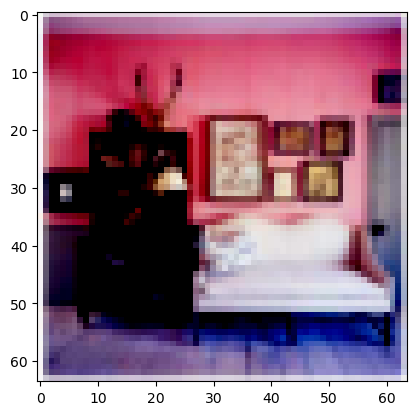

In [10]:
ds = image_dataset()
print(len(ds))
img1 = ds[1]
plt.imshow(img1.numpy().transpose(1,2,0))


In [13]:
batch_size = 256
num_samples = 300000
sampler = RandomSampler(ds,replacement=False,num_samples=num_samples)
dataloader = DataLoader(ds,batch_size,sampler=sampler)
len(dataloader)

1172

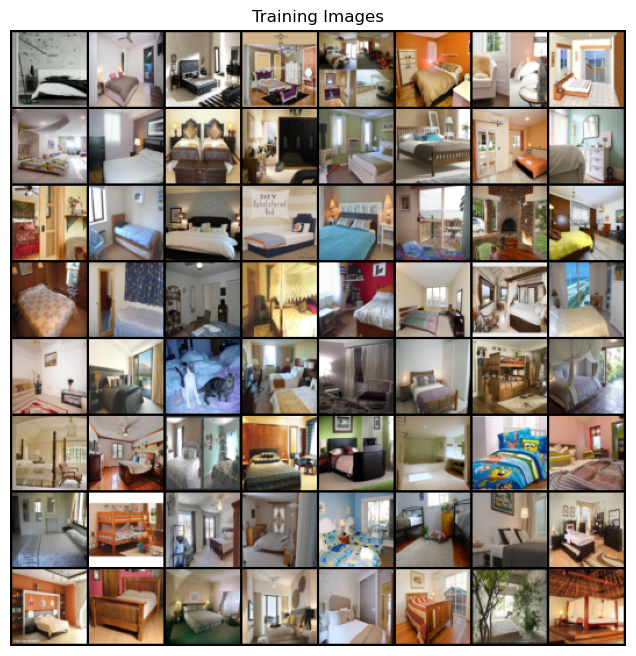

In [14]:
real_batch = next(iter(dataloader))
real_batch.shape
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# training routine

In [15]:
true_label = 0.95
false_label = 0.05
def train_discriminator(discriminator,fake_data,real_data,loss_fn,optimizer):
    optimizer.zero_grad()
    pred_fake = discriminator(fake_data)
    loss_fake = loss_fn(pred_fake,torch.full(size=(len(fake_data),1),fill_value=false_label).to(device))
    loss_fake.backward()
    pred_real = discriminator(real_data)
    loss_real = loss_fn(pred_real,torch.full(size=(len(real_data),1),fill_value=true_label).to(device))
    loss_real.backward()
    optimizer.step()
    return loss_real, loss_fake
def train_generator(discriminator, fake_data, loss_fn, optimizer):
    optimizer.zero_grad()
    pred = discriminator(fake_data)
    loss = loss_fn(pred,torch.full(size=(len(fake_data),1),fill_value=true_label).to(device))
    loss.backward()
    optimizer.step()
    return loss

In [16]:
def noise_generator(batch_size=128,noise_dim=1024):
    return torch.randn((batch_size,noise_dim)).to(device)

In [17]:
model_name = "baseline"
if not os.path.exists(model_name):
    os.makedirs(model_name)

In [19]:
beta1 = 0.5
beta2 = 0.9
loss_fn = torch.nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.AdamW(discriminator.parameters(),lr=1e-4,betas=(beta1,beta2))
g_optimizer = torch.optim.AdamW(generator.parameters(),lr=1e-4,betas=(beta1,beta2))

EPOCH: 1.000  d_loss: 0.860  g_loss: 3.892  (1258.41s - 23909.84s remaining)
EPOCH: 2.000  d_loss: 0.624  g_loss: 4.162  (2498.74s - 22488.65s remaining))


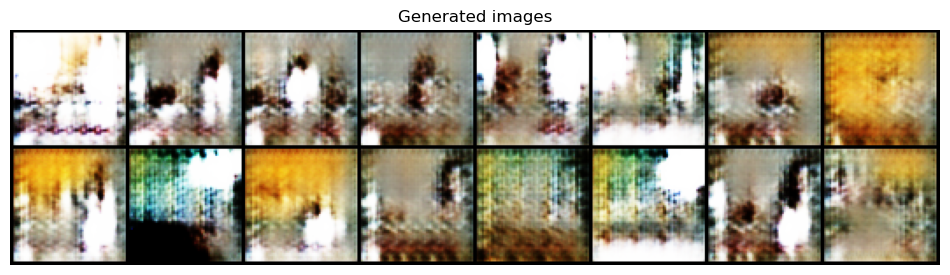

EPOCH: 3.000  d_loss: 0.726  g_loss: 4.249  (3697.74s - 20953.88s remaining))
EPOCH: 4.000  d_loss: 0.675  g_loss: 4.168  (4844.02s - 19376.07s remaining))


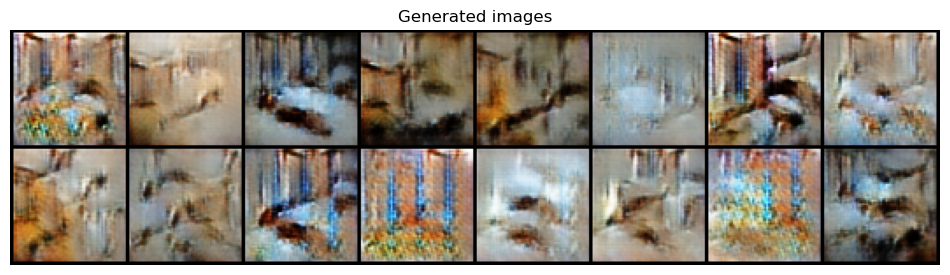

EPOCH: 4.485  g_loss: 3.046  d_loss: 0.484  (5415.79s - 18732.22s remaining)

In [20]:
N = len(dataloader)
num_epochs = 20
log = Report(num_epochs)
repeat_generator=1
noise_dim = 256
batch_size = 256
record_every = 1
show_every = 2
normalize = True


for epoch in range(num_epochs):
    for idx, imgs in enumerate(dataloader):
        real_data = imgs.to(device)
        fake_data = generator(noise_generator(batch_size,noise_dim).to(device))
        fake_data = fake_data.detach()
        real_loss, fake_loss = train_discriminator(discriminator,fake_data,real_data,loss_fn,d_optimizer)
        real_loss, fake_loss = real_loss.item(), fake_loss.item()
        d_total = real_loss + fake_loss
        g_total = 0
        g_batch = 0
        #while g_avg >= 3:
        for i in range(repeat_generator):
            fake_data = generator(noise_generator(batch_size,noise_dim).to(device))
            g_loss = train_generator(discriminator,fake_data,loss_fn,g_optimizer)
            g_total += g_loss.item()

        log.record(epoch+(idx+1)/N,g_loss = g_total, d_loss = d_total, end='\r')
    if (epoch+1)%record_every  == 0:
        log.report_avgs(epoch+1)
    if (epoch+1)%show_every == 0:
        torch.save(generator.state_dict(),model_name+r'/generator'+str(epoch+1)+'.pth')
        torch.save(discriminator.state_dict(),model_name+r'/discriminator'+str(epoch+1)+'.pth')
        torch.save(d_optimizer.state_dict(),model_name+r'/d_optimizer'+str(epoch+1)+'.pth')
        torch.save(g_optimizer.state_dict(),model_name+r'/g_optimizer'+str(epoch+1)+'.pth')
        generator.eval()
        noise = torch.randn(16, noise_dim, device=device)
        sample_images = generator(noise).detach().cpu()
        grid = torchvision.utils.make_grid(sample_images, nrow=8, normalize=normalize)
        show(grid.cpu().detach().permute(1,2,0), sz=12, title='Generated images')
log.plot_epochs(['g_loss','d_loss'])